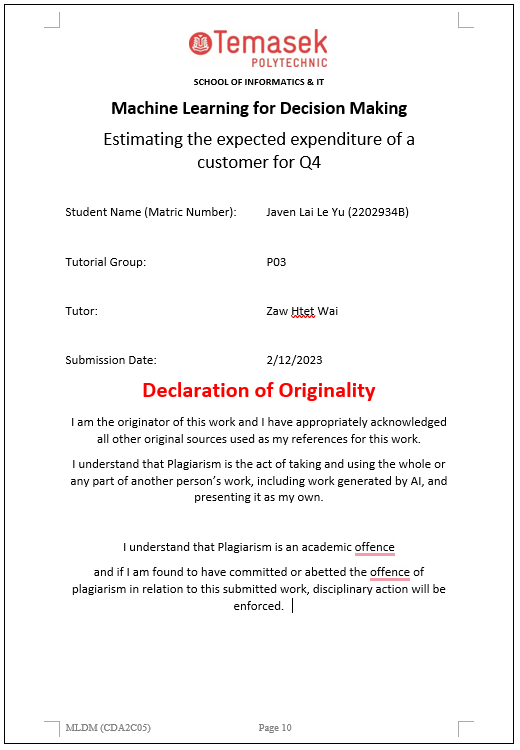

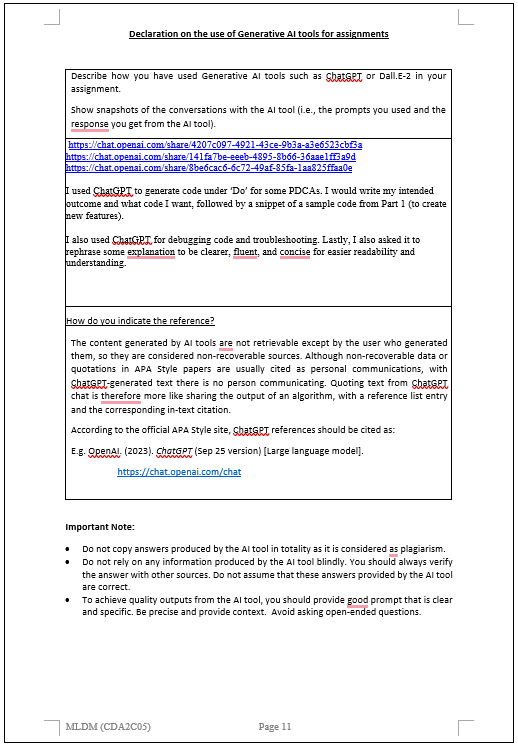

# Solution Part 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold, ShuffleSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from collections import defaultdict
from category_encoders.target_encoder import TargetEncoder 
SEED = 2202934
plt.rcParams["figure.figsize"] = (16,6)

In [2]:
dataset = pd.read_csv("synthetic_data.csv")

In [3]:
dataset.head()

,Datetime,Product_ID,Category,Quantity,Unit_Price,Customer_ID
0,2022-01-07,10106959,Stationery,9,1.579875,a225207859
1,2022-01-09,90097406,Sports,4,196.253377,a225207859
2,2022-01-10,10010465,Electronics,1,825.374291,a225207859
3,2022-01-14,10010510,Electronics,2,325.965035,a225207859
4,2022-01-16,40049430,Books,1,22.601919,a225207859


In [4]:
dataset.tail()

,Datetime,Product_ID,Category,Quantity,Unit_Price,Customer_ID
331659,2022-12-18,20026116,Groceries,5,5.378162,c891387366
331660,2022-12-23,10018925,Electronics,1,1193.828519,c891387366
331661,2022-12-27,20022820,Groceries,3,5.175492,c891387366
331662,2022-12-27,40042985,Books,2,38.598536,c891387366
331663,2022-12-31,20025163,Groceries,3,5.397744,c891387366


In [5]:
dataset.columns = dataset.columns.str.lower()

In [6]:
#create new column "expense" with unit_price*quantity
dataset["expense"] = dataset["unit_price"]*dataset["quantity"]

In [7]:
#read event_time as datetime
dataset['datetime'] = pd.to_datetime(dataset['datetime'], format='%Y-%m-%d')

In [8]:
dataset['datetime'] = pd.to_datetime(dataset['datetime'])
dataset['year'] = dataset['datetime'].dt.year
dataset['quarter'] = dataset['datetime'].dt.to_period("Q")

# Calculate the 'expense' column
dataset['expense'] = dataset['unit_price'] * dataset['quantity']

# Initialize an empty DataFrame to store transformed dataset
df = pd.DataFrame()

# Loop through each quarter in 2022 to perform aggregations
for quarter in dataset[dataset['year'] == 2022]['quarter'].unique():
    temp_df = dataset[(dataset['quarter'] == quarter) & (dataset['year'] == 2022)].copy()

    grouped = temp_df.groupby('customer_id').agg(
        total_items=('product_id', 'count'),
        total_expense=('expense', 'sum'),
        total_categories=('category', 'count'),
    ).reset_index()
    
    # Rename columns to indicate the quarter
    grouped.columns = [f"{col}_{quarter}" if col != 'customer_id' else col for col in grouped.columns]
    
    # Merge this quarter's data into the final DataFrame
    if df.empty:
        df = grouped
    else:
        df = pd.merge(df, grouped, on='customer_id', how='outer')
        
# Create a df without features beyond 2022Q3 except for Target
final_df = df.copy()

# Identify columns related to quarters beyond 2022Q3 excluding Target
columns_to_drop = [col for col in final_df.columns if '2022Q4' in col and col != 'total_expense_2022Q4']

# Drop the identified columns
final_df = final_df.drop(columns=columns_to_drop)
        
# Show the resulting DataFrame
final_df.head().transpose()

,0,1,2,3,4
customer_id,a001192674,a001713895,a002096298,a002306341,a003157865
total_items_2022Q1,29,30,30,24,20
total_expense_2022Q1,6069.341932,6888.929143,6616.97386,4480.895657,6120.452162
total_categories_2022Q1,29,30,30,24,20
total_items_2022Q2,28,24,30,23,29
total_expense_2022Q2,4991.923424,4629.708661,6825.834052,7869.628291,7768.157905
total_categories_2022Q2,28,24,30,23,29
total_items_2022Q3,27,30,27,22,23
total_expense_2022Q3,5642.684311,6486.449628,5724.875642,4197.345032,5734.627161
total_categories_2022Q3,27,30,27,22,23


In [9]:
TARGET_COLUMN = 'total_expense_2022Q4'

# Drop Q4-related features and 'customer_id'
drop_columns = [col for col in final_df.columns if '2022Q4' in col or col == 'customer_id']
X = final_df.drop(drop_columns + [TARGET_COLUMN], axis=1)
y =  final_df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


model = DecisionTreeRegressor(random_state=SEED)
# Fit the model
model.fit(X_train, y_train)
# Predict on the test set
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

In [10]:
# Predict on the training set
y_pred_train = model.predict(X_train)

# Evaluate on the training set
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Print evaluation metrics
print(f"Mean Absolute Percentage Error on Train Set: {mape_train:.2f}")
print(f"R-squared on Train Set: {r2_train:.2f}")

Mean Absolute Percentage Error on Train Set: 0.00
R-squared on Train Set: 1.00


In [11]:
# Evaluate on the test set
mape_test = mean_absolute_percentage_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Percentage Error on Test Set: {mape_test:.2f}")
print(f"R-squared on Test Set: {r2_test:.2f}")

Mean Absolute Percentage Error on Test Set: 0.40
R-squared on Test Set: 0.63


# Solution Part 2

### For storing model performance

In [12]:
# setup df to contain all scores across various "engineering" or PDCA cycles, for easy reading
results = pd.DataFrame(columns=['Model', 'MAPE Test', 'R2 Test', 'MAPE Train', 'R2 Train', 'Parameters'])

In [13]:
def store_model(model_name, mape_test, r2_test, mape_train, r2_train, best_params=None):
    global results
    
    # Store the model and metrics in the DataFrame
    new_row = pd.DataFrame({
        'Model': [model_name],
        'MAPE Test': [mape_test],
        'R2 Test': [r2_test],
        'MAPE Train': [mape_train],
        'R2 Train': [r2_train],
        'Parameters': [best_params]
    })
    
    results = pd.concat([results, new_row], ignore_index=True)
    display(results)

In [14]:
store_model('Benchmark DTR', mape_test, r2_test, mape_train, r2_train)

,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None


### Evaluate Model Performance

In [15]:
def evaluate_model(model, X, y, type):
    """
    Evaluate the performance of a regression model on the given dataset.

    Parameters:
    - model: The regression model to evaluate.
    - X: The feature matrix.
    - y: The target variable.
    - type: Train or Test

    Returns:
    - mape: Mean Absolute Percentage Error
    - r2: R-squared
    """
    # Predict on the given dataset
    y_pred = model.predict(X)

    # Calculate metrics
    mape = mean_absolute_percentage_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # print metrics
    print(f"Mean Absolute Percentage Error on {type} Set: {mape:.2f}")
    print(f"R-squared on {type} Set: {r2:.2f}")

    return mape, r2

## 1. Model Pruning

### Plan:
Decision Tree Regressor (DTR) is overfitted due to the disparity in performance for training and validation set. Hence, the model requires pruning to restrict the model from overgrowing. To prevent overgrowing (which causes overfitting), I will perform hyperparameter tuning.

### Do:
I use GridSearch to identify the best-performing set of hyperparameters for the DTR.

In [16]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 5, 10, 15],             # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],   # Maximum number of features considered for splitting a node
    'max_leaf_nodes': [None, 10, 20, 30],       # Maximum number of leaf nodes in the tree
    'min_impurity_decrease': [0.0, 0.1, 0.2]    # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
}

In [17]:
def param_tuning(model, X_train, y_train): 
    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters: {best_params}")
    return best_params

### Check:
I will fine-tune my DTR using the best set of hyperparameters and evaluate the performance on training set to see if model can generalize well with unseen data after pruning.

In [18]:
# Find best params using grid search
best_params = param_tuning(model, X_train, y_train)

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [19]:
# Train the Decision Tree with the best hyperparameters
best_model = DecisionTreeRegressor(**best_params, random_state=SEED)
best_model.fit(X_train, y_train)

DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=10,
                      random_state=2202934)

In [20]:
mape_train, r2_train = evaluate_model(best_model, X_train, y_train, 'Train')

Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84


In [21]:
mape_test, r2_test = evaluate_model(best_model, X_test, y_test, 'Test')

Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


### Act:
This Model Pruning process is successful as the R-squared and MAPE for both train and test are consistently well performing. Hence, the changes implemented will be kept.

In [22]:
store_model('Hyperparameter tuning', mape_test, r2_test, mape_train, r2_train, best_params)

,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."


## 2. Understanding engagement of different customer types

### Plan:
Based on EDA, I identified 4 potential customer types. This PDCA Cycle aims to include a feature 'customer_type' to represent customer types A, B, C, and D, so that the Model can differentiate and learn the customer engagement pattern of various customer types and enable me to generate deeper insights on customer engagement of each customer type at Retail Hypermarket.

In [23]:
#save point
df_customer_type = final_df.copy()
df_customer_type.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4
0,a001192674,29,6069.341932,29,28,4991.923424,28,27,5642.684311,27,9901.777797
1,a001713895,30,6888.929143,30,24,4629.708661,24,30,6486.449628,30,5642.928052
2,a002096298,30,6616.973860,30,30,6825.834052,30,27,5724.875642,27,4643.727610
3,a002306341,24,4480.895657,24,23,7869.628291,23,22,4197.345032,22,6567.149577
4,a003157865,20,6120.452162,20,29,7768.157905,29,23,5734.627161,23,9050.380186


### Do:

1. Slice the first letter of customer id as customer type.

In [24]:
df_customer_type['customer_type'] = df_customer_type['customer_id'].str[0]

In [25]:
df_customer_type.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type
0,a001192674,29,6069.341932,29,28,4991.923424,28,27,5642.684311,27,9901.777797,a
1,a001713895,30,6888.929143,30,24,4629.708661,24,30,6486.449628,30,5642.928052,a
2,a002096298,30,6616.973860,30,30,6825.834052,30,27,5724.875642,27,4643.727610,a
3,a002306341,24,4480.895657,24,23,7869.628291,23,22,4197.345032,22,6567.149577,a
4,a003157865,20,6120.452162,20,29,7768.157905,29,23,5734.627161,23,9050.380186,a


2. Since customer type is categorical, I need to encode customer type for it to be usable by the model. I will test common encoding methods to find the most optimal encoding (best performance) method to apply on customer type.

One-hot encoding:

In [26]:
df_customer_type_1 = df_customer_type.copy()

In [27]:
# One-Hot Encoding
def one_hot_encode(df, columns_to_encode):
    one_hot = pd.get_dummies(df[columns_to_encode])         # Create new col for each unique value in encoded column
    df = pd.concat([df, one_hot], axis=1)                   # Concatenate encoded columns with the original DataFrame
    df = df.drop(columns=columns_to_encode)                 # Drop cols after encoded
    
    return df

df_customer_type_1 = one_hot_encode(df_customer_type, ['customer_type']) # one-hot encode customer type

In [28]:
df_customer_type_1.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type_a,customer_type_b,customer_type_c,customer_type_d
0,a001192674,29,6069.341932,29,28,4991.923424,28,27,5642.684311,27,9901.777797,1,0,0,0
1,a001713895,30,6888.929143,30,24,4629.708661,24,30,6486.449628,30,5642.928052,1,0,0,0
2,a002096298,30,6616.973860,30,30,6825.834052,30,27,5724.875642,27,4643.727610,1,0,0,0
3,a002306341,24,4480.895657,24,23,7869.628291,23,22,4197.345032,22,6567.149577,1,0,0,0
4,a003157865,20,6120.452162,20,29,7768.157905,29,23,5734.627161,23,9050.380186,1,0,0,0


Target encoding:

In [29]:
df_customer_type_2 = df_customer_type.copy()

In [30]:
# Target Encoding
def target_encode(df, columns_to_encode, target_column):
    target_encoders = {}                                      # Dictionary to store target encoders for each column
    df_encoded = df.copy()                                    # Create a copy of the DataFrame to avoid modifying the original

    for col in columns_to_encode:
        target_encoder = TargetEncoder()                            # Init the TargetEncoder
        df_encoded[col + '_encoded'] = target_encoder.fit_transform(df_encoded[col], df_encoded[target_column])  # Fit and transform the column
        target_encoders[col] = target_encoder                       # Store the target encoder in the dictionary

    df_encoded.drop(columns=columns_to_encode, inplace=True)  # Drop the original columns
    return df_encoded, target_encoders

df_customer_type_2, target_encoders = target_encode(df_customer_type_2, ['customer_type'], TARGET_COLUMN)

In [31]:
df_customer_type_2.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type_encoded
0,a001192674,29,6069.341932,29,28,4991.923424,28,27,5642.684311,27,9901.777797,9835.142826
1,a001713895,30,6888.929143,30,24,4629.708661,24,30,6486.449628,30,5642.928052,9835.142826
2,a002096298,30,6616.973860,30,30,6825.834052,30,27,5724.875642,27,4643.727610,9835.142826
3,a002306341,24,4480.895657,24,23,7869.628291,23,22,4197.345032,22,6567.149577,9835.142826
4,a003157865,20,6120.452162,20,29,7768.157905,29,23,5734.627161,23,9050.380186,9835.142826


In [32]:
df_customer_type_2.customer_type_encoded.unique()

array([9835.14282574, 8905.9432254 , 9621.87196284, 9838.50287716])

Ordinal encoding:
> In order to ordinal encode, I need to rank each customer type based on their average spending behavior.

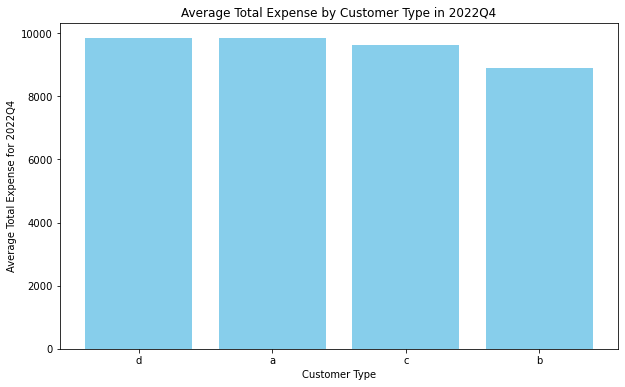

In [33]:
target_col = 'total_expense_2022Q4' # adjust other Quarters to see trend

# Group data by customer_type and calculate average total_expense
average_expense_by_type = df_customer_type.groupby('customer_type')[target_col].mean().reset_index()

# Sort the DataFrame by average total_expense in descending order
average_expense_by_type = average_expense_by_type.sort_values(by=target_col, ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(average_expense_by_type['customer_type'], average_expense_by_type[target_col], color='skyblue')
plt.xlabel('Customer Type')
plt.ylabel('Average Total Expense for 2022Q4')
plt.title('Average Total Expense by Customer Type in 2022Q4')
plt.show()

- Customer Type d, a, c have closely similar average spending for all quarters. Customer Type A are top spending customers for Q1 to Q2, followed by Type D. Type C is the 2nd top spending customer type for Q3.

- However, customer Type b has the least average expenditure for all quarters.

I will try 2 different ordinal encoding:
1. d,a,c as 1 and b as 0 since d,a,c are more valuable customers as they spend more money.
2. d,a as 2, c as 1, and b as 0. (To differentiate customer types further)

In [34]:
df_customer_type_3 = df_customer_type.copy()

# Ordinal Encoding 1
encoding_customer_type_3 = {'b': 0, 'a': 1, 'c': 1, 'd': 1}

# Apply the mapping to the 'customer_type' column
df_customer_type_3['customer_type_encoded'] = df_customer_type_3['customer_type'].map(encoding_customer_type_3)

# Drop the original 'customer_type' column
df_customer_type_3.drop(columns=['customer_type'], inplace=True)

df_customer_type_3.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type_encoded
0,a001192674,29,6069.341932,29,28,4991.923424,28,27,5642.684311,27,9901.777797,1
1,a001713895,30,6888.929143,30,24,4629.708661,24,30,6486.449628,30,5642.928052,1
2,a002096298,30,6616.973860,30,30,6825.834052,30,27,5724.875642,27,4643.727610,1
3,a002306341,24,4480.895657,24,23,7869.628291,23,22,4197.345032,22,6567.149577,1
4,a003157865,20,6120.452162,20,29,7768.157905,29,23,5734.627161,23,9050.380186,1


In [35]:
df_customer_type_4 = df_customer_type.copy()

# Ordinal Encoding 1
encoding_customer_type_4 = {'b': 0, 'a': 2, 'c': 1, 'd': 2}

# Apply the mapping to the 'customer_type' column
df_customer_type_4['customer_type_encoded'] = df_customer_type_4['customer_type'].map(encoding_customer_type_4)

# Drop the original 'customer_type' column
df_customer_type_4.drop(columns=['customer_type'], inplace=True)

df_customer_type_4.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type_encoded
0,a001192674,29,6069.341932,29,28,4991.923424,28,27,5642.684311,27,9901.777797,2
1,a001713895,30,6888.929143,30,24,4629.708661,24,30,6486.449628,30,5642.928052,2
2,a002096298,30,6616.973860,30,30,6825.834052,30,27,5724.875642,27,4643.727610,2
3,a002306341,24,4480.895657,24,23,7869.628291,23,22,4197.345032,22,6567.149577,2
4,a003157865,20,6120.452162,20,29,7768.157905,29,23,5734.627161,23,9050.380186,2


### Check:

In [36]:
# automate checking process
def check_performance(name, df, exclude=None, target=TARGET_COLUMN, params='', SEED=SEED):
    
    # train_test_split PREDICTORS AND TARGET
    if exclude:
        X = df.drop(columns=[target, exclude])
        
    else:
        X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED) # holdout strategy
    
    # Train a Decision Tree Regressor with the new features
    customer_model = DecisionTreeRegressor(**params, random_state=SEED)
    customer_model.fit(X_train, y_train)

    # Print feature importances
    feature_importances = list(zip(X.columns, customer_model.feature_importances_))
    feature_importances_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    print(feature_importances_df)
    
    print('Training performance')
    mape_train, r2_train = evaluate_model(customer_model, X_train, y_train, 'Train')
    
    print('\nTesting performance')
    mape_test, r2_test = evaluate_model(customer_model, X_test, y_test, 'Test')
    
    store_model(name, mape_test, r2_test, mape_train, r2_train, list(X.columns))

In [37]:
check_performance('one-hot customer', df_customer_type_1, exclude='customer_id', params=best_params)

                    Feature  Importance
3        total_items_2022Q2    0.990335
4      total_expense_2022Q2    0.002955
1      total_expense_2022Q1    0.002252
5   total_categories_2022Q2    0.001754
7      total_expense_2022Q3    0.001731
6        total_items_2022Q3    0.000973
0        total_items_2022Q1    0.000000
2   total_categories_2022Q1    0.000000
8   total_categories_2022Q3    0.000000
9           customer_type_a    0.000000
10          customer_type_b    0.000000
11          customer_type_c    0.000000
12          customer_type_d    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."


In [38]:
check_performance('target-encode customer', df_customer_type_2, exclude='customer_id', params=best_params)

                   Feature  Importance
3       total_items_2022Q2    0.994809
0       total_items_2022Q1    0.002136
8  total_categories_2022Q3    0.001428
4     total_expense_2022Q2    0.001017
1     total_expense_2022Q1    0.000610
2  total_categories_2022Q1    0.000000
5  total_categories_2022Q2    0.000000
6       total_items_2022Q3    0.000000
7     total_expense_2022Q3    0.000000
9    customer_type_encoded    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.83


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."


In [39]:
check_performance('ordinal-encode customer', df_customer_type_3, exclude='customer_id', params=best_params)

                   Feature  Importance
3       total_items_2022Q2    0.995751
8  total_categories_2022Q3    0.001428
0       total_items_2022Q1    0.001194
4     total_expense_2022Q2    0.001017
1     total_expense_2022Q1    0.000610
2  total_categories_2022Q1    0.000000
5  total_categories_2022Q2    0.000000
6       total_items_2022Q3    0.000000
7     total_expense_2022Q3    0.000000
9    customer_type_encoded    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.83


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."


In [40]:
check_performance('ordinal encode 2 customer', df_customer_type_4, exclude='customer_id', params=best_params)

                   Feature  Importance
3       total_items_2022Q2    0.994809
0       total_items_2022Q1    0.002136
8  total_categories_2022Q3    0.001428
4     total_expense_2022Q2    0.001017
1     total_expense_2022Q1    0.000610
2  total_categories_2022Q1    0.000000
5  total_categories_2022Q2    0.000000
6       total_items_2022Q3    0.000000
7     total_expense_2022Q3    0.000000
9    customer_type_encoded    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.83


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
Choosing either target encoding or ordinal encoding for customer type results in very slight improvement in model accuracy (MAPE) and explainability (R-Square), indicating that customer type likely plays a role in influencing customer spending patterns. 

Since target and ordinal produces the same results for Decision Tree, ordinal encoding is preferred due to its simplicity in understanding the represented values (differentiate Type B as weak spender). Ordinal encoding also preserves the model's reusability for future predictions, since potential changes in customer spending would make the old encoded values inaccurate in meaning.

Implementing customer type enhances the model's accuracy, explainability, and facilitates the creation of customized business strategies for normal spenders and weak spenders.

In [41]:
df_expenses = df_customer_type_3.copy()
df_expenses.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type_encoded
0,a001192674,29,6069.341932,29,28,4991.923424,28,27,5642.684311,27,9901.777797,1
1,a001713895,30,6888.929143,30,24,4629.708661,24,30,6486.449628,30,5642.928052,1
2,a002096298,30,6616.973860,30,30,6825.834052,30,27,5724.875642,27,4643.727610,1
3,a002306341,24,4480.895657,24,23,7869.628291,23,22,4197.345032,22,6567.149577,1
4,a003157865,20,6120.452162,20,29,7768.157905,29,23,5734.627161,23,9050.380186,1


## 3. Comprehensibility of Prices

### Plan:
During EDA, it was discovered that the unit_prices are non-terminating numbers. This leads to expenses being calculated in a non-terminating format, making it unconventional in the context of supermarket transactions because prices of products do not go below cents (2 decimal places). Hence, I will round off the expenses to 2 d.p. to make the prices comprehensible for business users.

### Do:

In [42]:
df_expenses = df_expenses.round(2)
df_expenses.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type_encoded
0,a001192674,29,6069.34,29,28,4991.92,28,27,5642.68,27,9901.78,1
1,a001713895,30,6888.93,30,24,4629.71,24,30,6486.45,30,5642.93,1
2,a002096298,30,6616.97,30,30,6825.83,30,27,5724.88,27,4643.73,1
3,a002306341,24,4480.90,24,23,7869.63,23,22,4197.35,22,6567.15,1
4,a003157865,20,6120.45,20,29,7768.16,29,23,5734.63,23,9050.38,1


### Check:

In [43]:
X = df_expenses.drop(columns=['total_expense_2022Q4', 'customer_id'])
y = df_expenses['total_expense_2022Q4']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

In [45]:
# Train a Decision Tree Regressor with the new features
expenses_model = DecisionTreeRegressor(**best_params, random_state=SEED)
expenses_model.fit(X_train, y_train)

DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=10,
                      random_state=2202934)

In [46]:
mape_train, r2_train = evaluate_model(expenses_model, X_train, y_train, 'Train')

Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84


In [47]:
mape_test, r2_test = evaluate_model(expenses_model, X_test, y_test, 'Test')

Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.83


In [48]:
store_model('Expenses DTR', mape_test, r2_test, mape_train, r2_train, list(X.columns))

,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
Insignificant impact on Model performance. This change will be implemented as it improves interpretability of expenses values for business usage.

In [49]:
df_cat = df_expenses.copy()
df_cat.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type_encoded
0,a001192674,29,6069.34,29,28,4991.92,28,27,5642.68,27,9901.78,1
1,a001713895,30,6888.93,30,24,4629.71,24,30,6486.45,30,5642.93,1
2,a002096298,30,6616.97,30,30,6825.83,30,27,5724.88,27,4643.73,1
3,a002306341,24,4480.90,24,23,7869.63,23,22,4197.35,22,6567.15,1
4,a003157865,20,6120.45,20,29,7768.16,29,23,5734.63,23,9050.38,1


## 4. How many categories a customer purchased from for each quarter

### Plan:
This PDCA cycle aims to understand how customer engaging in multiple product categories influence the customer engagement in Q4. Does purchasing from more category corresponds to having more customer engagement and higher spending from that customer?

### Do:

In [50]:
dataset.head()

,datetime,product_id,category,quantity,unit_price,customer_id,expense,year,quarter
0,2022-01-07,10106959,Stationery,9,1.579875,a225207859,14.218879,2022,2022Q1
1,2022-01-09,90097406,Sports,4,196.253377,a225207859,785.013510,2022,2022Q1
2,2022-01-10,10010465,Electronics,1,825.374291,a225207859,825.374291,2022,2022Q1
3,2022-01-14,10010510,Electronics,2,325.965035,a225207859,651.930069,2022,2022Q1
4,2022-01-16,40049430,Books,1,22.601919,a225207859,22.601919,2022,2022Q1


In [51]:
for quarter in dataset[dataset['year'] == 2022]['quarter'].unique():
        
    temp_df = dataset[(dataset['quarter'] == quarter) & (dataset['year'] == 2022)].copy()

    grouped = temp_df.groupby('customer_id').agg(
        unique_categories=('category', 'nunique')  # New aggregation for unique categories
    ).reset_index()
    
    # Rename columns to indicate the quarter
    grouped.columns = [f"{col}_{quarter}" if col != 'customer_id' else col for col in grouped.columns]
    
    # Merge info with current dataset
    df_cat = pd.merge(df_cat, grouped, on='customer_id', how='outer')

In [52]:
df_cat.drop(columns=['unique_categories_2022Q4'], inplace=True) # cannot use anything related to Q4 as this causes target leakage

In [53]:
df_cat.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type_encoded,unique_categories_2022Q1,unique_categories_2022Q2,unique_categories_2022Q3
0,a001192674,29,6069.34,29,28,4991.92,28,27,5642.68,27,9901.78,1,9,9,8
1,a001713895,30,6888.93,30,24,4629.71,24,30,6486.45,30,5642.93,1,7,5,7
2,a002096298,30,6616.97,30,30,6825.83,30,27,5724.88,27,4643.73,1,6,7,5
3,a002306341,24,4480.90,24,23,7869.63,23,22,4197.35,22,6567.15,1,7,8,8
4,a003157865,20,6120.45,20,29,7768.16,29,23,5734.63,23,9050.38,1,8,9,9


### Check:

In [54]:
check_performance('unique categories', df_cat, exclude='customer_id', params=best_params)

                     Feature  Importance
3         total_items_2022Q2    0.992816
5    total_categories_2022Q2    0.001512
0         total_items_2022Q1    0.001110
10  unique_categories_2022Q1    0.001075
6         total_items_2022Q3    0.000975
2    total_categories_2022Q1    0.000929
4       total_expense_2022Q2    0.000916
1       total_expense_2022Q1    0.000666
7       total_expense_2022Q3    0.000000
8    total_categories_2022Q3    0.000000
9      customer_type_encoded    0.000000
11  unique_categories_2022Q2    0.000000
12  unique_categories_2022Q3    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
Based on Feature Importances and performance metrics, the addition of these features does NOT improve performance nor explainability of the model. This indicates that the new features are unmeaningful as there is no impactful pattern for the machine to learn from how many categories a customer purchased from for each quarter.

Therefore, I will **reject this PDCA** as the features have no impactful benefits, hence should not be implemented as its not useful.

In [55]:
df_catcount = df_expenses.copy() # backtrace to expenses

## 5. Count of items purchased in each category for Q1-Q3

### Plan:
This PDCA cycle aims to understand and predict customer engagement based on how a customer engages in different product categories and how it can be used to predict a customer's expected spending for the future quarter.

In [56]:
df_catcount.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type_encoded
0,a001192674,29,6069.34,29,28,4991.92,28,27,5642.68,27,9901.78,1
1,a001713895,30,6888.93,30,24,4629.71,24,30,6486.45,30,5642.93,1
2,a002096298,30,6616.97,30,30,6825.83,30,27,5724.88,27,4643.73,1
3,a002306341,24,4480.90,24,23,7869.63,23,22,4197.35,22,6567.15,1
4,a003157865,20,6120.45,20,29,7768.16,29,23,5734.63,23,9050.38,1


In [57]:
dataset.head()

,datetime,product_id,category,quantity,unit_price,customer_id,expense,year,quarter
0,2022-01-07,10106959,Stationery,9,1.579875,a225207859,14.218879,2022,2022Q1
1,2022-01-09,90097406,Sports,4,196.253377,a225207859,785.013510,2022,2022Q1
2,2022-01-10,10010465,Electronics,1,825.374291,a225207859,825.374291,2022,2022Q1
3,2022-01-14,10010510,Electronics,2,325.965035,a225207859,651.930069,2022,2022Q1
4,2022-01-16,40049430,Books,1,22.601919,a225207859,22.601919,2022,2022Q1


### Do:

In [58]:
# Filter the original DataFrame for Q1 to Q3 of 2022
dataset['quarter'] = dataset['quarter'].astype(str)                             # Convert the 'quarter' column to strings
filtered_df = dataset[dataset['quarter'].isin(['2022Q1', '2022Q2', '2022Q3'])]

# Create a pivot table to get the category counts for each customer
category_count_df = filtered_df.pivot_table(
    index='customer_id',
    columns='category',
    values='quantity',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Merge the category count DataFrame with the current DataFrame
df_catcount = pd.merge(df_catcount, category_count_df, on='customer_id', how='left')

# Fill NaN values with 0 for customers who haven't bought products from a specific category
df_catcount.fillna(0, inplace=True)

In [59]:
df_catcount.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,...,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys
0,a001192674,29,6069.34,29,28,4991.92,28,27,5642.68,27,...,14,14,18,10,0,223,31,13,21,41
1,a001713895,30,6888.93,30,24,4629.71,24,30,6486.45,30,...,2,7,3,3,3,964,11,7,19,7
2,a002096298,30,6616.97,30,30,6825.83,30,27,5724.88,27,...,5,0,1,5,3,1015,2,7,57,14
3,a002306341,24,4480.90,24,23,7869.63,23,22,4197.35,22,...,18,8,16,5,4,119,34,9,82,27
4,a003157865,20,6120.45,20,29,7768.16,29,23,5734.63,23,...,9,19,5,8,6,126,21,18,48,12


### Check:

In [60]:
check_performance('categories count', df_catcount, exclude='customer_id', params=best_params)

                    Feature  Importance
3        total_items_2022Q2    0.989430
4      total_expense_2022Q2    0.004135
11                    Books    0.002803
18               Stationery    0.001765
13              Electronics    0.000939
10               Automotive    0.000929
17                   Sports    0.000000
16          Health & Beauty    0.000000
15                Groceries    0.000000
14                Furniture    0.000000
12                 Clothing    0.000000
0        total_items_2022Q1    0.000000
1      total_expense_2022Q1    0.000000
9     customer_type_encoded    0.000000
8   total_categories_2022Q3    0.000000
7      total_expense_2022Q3    0.000000
6        total_items_2022Q3    0.000000
5   total_categories_2022Q2    0.000000
2   total_categories_2022Q1    0.000000
19                     Toys    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test 

,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
Based on Features Importances, the count of categories for certain categories are meaningful in predicting customer spending in Q4. This indicates that the newly generated features could be useful to explain and predict customer spending. However, the model performance and explainability worsen slightly, and I believe this is due to curse of dimensionality where the Model is overloaded with too many features to learn from.

This leads me to the next PDCA cycle...

## 6. Features Selection

### Plan:
Now that the Model is overloaded with a bunch of features, its time to evaluate the usefulness of the features and identify relevant features to be used as meaningful predictors.

### Do:

In [61]:
df_select = df_catcount.copy()

#### Pearson's Correlation Test

In [62]:
# Calculate the correlation matrix
corr_mat = df_select.corr()

# Display the correlation matrix with a blue color gradient
corr_mat.style.background_gradient(cmap='Blues')

,total_items_2022Q1,total_expense_2022Q1,total_categories_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_categories_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_categories_2022Q3,total_expense_2022Q4,customer_type_encoded,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys
total_items_2022Q1,1.000000,0.922950,1.000000,0.869373,0.851799,0.869373,0.872623,0.850162,0.872623,0.842149,0.037807,0.805896,-0.173085,-0.148372,0.802359,0.809821,0.698500,-0.205244,-0.139405,-0.168549,-0.161158
total_expense_2022Q1,0.922950,1.000000,0.922950,0.841242,0.847217,0.841242,0.850095,0.848361,0.850095,0.842224,0.043445,0.818241,-0.142198,-0.110384,0.857119,0.878729,0.582799,-0.139217,-0.085094,-0.141487,-0.122834
total_categories_2022Q1,1.000000,0.922950,1.000000,0.869373,0.851799,0.869373,0.872623,0.850162,0.872623,0.842149,0.037807,0.805896,-0.173085,-0.148372,0.802359,0.809821,0.698500,-0.205244,-0.139405,-0.168549,-0.161158
total_items_2022Q2,0.869373,0.841242,0.869373,1.000000,0.922085,1.000000,0.875199,0.853113,0.875199,0.836911,0.040346,0.787851,-0.178808,-0.167319,0.802002,0.802068,0.715430,-0.211367,-0.149480,-0.183311,-0.163126
total_expense_2022Q2,0.851799,0.847217,0.851799,0.922085,1.000000,0.922085,0.858898,0.858018,0.858898,0.845346,0.040570,0.804634,-0.148768,-0.121466,0.863234,0.881785,0.597099,-0.131597,-0.093729,-0.137689,-0.126137
total_categories_2022Q2,0.869373,0.841242,0.869373,1.000000,0.922085,1.000000,0.875199,0.853113,0.875199,0.836911,0.040346,0.787851,-0.178808,-0.167319,0.802002,0.802068,0.715430,-0.211367,-0.149480,-0.183311,-0.163126
total_items_2022Q3,0.872623,0.850095,0.872623,0.875199,0.858898,0.875199,1.000000,0.926780,1.000000,0.836551,0.038214,0.802309,-0.183568,-0.158888,0.811382,0.808584,0.710151,-0.205844,-0.157398,-0.178835,-0.161890
total_expense_2022Q3,0.850162,0.848361,0.850162,0.853113,0.858018,0.853113,0.926780,1.000000,0.926780,0.842222,0.036972,0.806585,-0.157395,-0.127240,0.865743,0.880959,0.598505,-0.151936,-0.101463,-0.137590,-0.126032
total_categories_2022Q3,0.872623,0.850095,0.872623,0.875199,0.858898,0.875199,1.000000,0.926780,1.000000,0.836551,0.038214,0.802309,-0.183568,-0.158888,0.811382,0.808584,0.710151,-0.205844,-0.157398,-0.178835,-0.161890
total_expense_2022Q4,0.842149,0.842224,0.842149,0.836911,0.845346,0.836911,0.836551,0.842222,0.836551,1.000000,0.058378,0.804220,-0.154825,-0.116876,0.808037,0.816264,0.573068,-0.168644,-0.110462,-0.133756,-0.134693


1. Multi-collinearity between total_items, total_expense, total_items, and categories: automotive, electronics, furniture, groceries.
2. total_items and total_categories have perfect R-Square suggesting that they are the same exact thing. **Hence, total_categories will be removed.**
3. customer type may be a meaningless predictor as it has an insignificant relationship with target.

In [63]:
cols_to_drop = df_select.filter(like='total_categories').columns
df_select.drop(columns=cols_to_drop, inplace=True)

In [64]:
df_select.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_expense_2022Q4,customer_type_encoded,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys
0,a001192674,29,6069.34,28,4991.92,27,5642.68,9901.78,1,14,14,18,10,0,223,31,13,21,41
1,a001713895,30,6888.93,24,4629.71,30,6486.45,5642.93,1,2,7,3,3,3,964,11,7,19,7
2,a002096298,30,6616.97,30,6825.83,27,5724.88,4643.73,1,5,0,1,5,3,1015,2,7,57,14
3,a002306341,24,4480.90,23,7869.63,22,4197.35,6567.15,1,18,8,16,5,4,119,34,9,82,27
4,a003157865,20,6120.45,29,7768.16,23,5734.63,9050.38,1,9,19,5,8,6,126,21,18,48,12


#### One-way ANOVA Test
To identify if a feature is a significant predictor.

#### Null Hypothesis:
The feature is not significantly related to the target variable.

#### Alternative Hypothesis:
The feature is significantly related to the target variable.

#### Confidence Level:
95%; Significance level of 0.05

In [65]:
import scipy.stats as stats
from scipy.stats import f_oneway
import itertools
from itertools import chain

In [66]:
cols_to_drop = []

for col in df_select.columns:
    groups = []
    
    # for the current col, check its relationship with the target
    for category, group_df in df_select.groupby(col):
        groups.append(group_df[TARGET_COLUMN])
        
    # extracting p-value from one-way ANOVA by passing all categorical columns
    f_value, p_value = f_oneway(*groups)
    print(f"ANOVA FOR {col}: p-value = {p_value:.12f}")
    
    # drop columns with p-value less than a threshold (e.g., 0.05)
    if p_value > 0.05:
        cols_to_drop.append(col)

C:\Users\javen\anaconda3\lib\site-packages\scipy\stats\stats.py:3629: F_onewayBadInputSizesWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(F_onewayBadInputSizesWarning(msg))


ANOVA FOR customer_id: p-value = nan
ANOVA FOR total_items_2022Q1: p-value = 0.000000000000
ANOVA FOR total_expense_2022Q1: p-value = 0.000008906970
ANOVA FOR total_items_2022Q2: p-value = 0.000000000000
ANOVA FOR total_expense_2022Q2: p-value = 0.000117636777
ANOVA FOR total_items_2022Q3: p-value = 0.000000000000
ANOVA FOR total_expense_2022Q3: p-value = 0.059203344652
ANOVA FOR total_expense_2022Q4: p-value = 0.000000000000
ANOVA FOR customer_type_encoded: p-value = 0.002653958073
ANOVA FOR Automotive: p-value = 0.000000000000
ANOVA FOR Books: p-value = 0.000064893028
ANOVA FOR Clothing: p-value = 0.023144192986
ANOVA FOR Electronics: p-value = 0.000000000000
ANOVA FOR Furniture: p-value = 0.000000000000
ANOVA FOR Groceries: p-value = 0.000000000000
ANOVA FOR Health & Beauty: p-value = 0.000011653973
ANOVA FOR Sports: p-value = 0.000166719952
ANOVA FOR Stationery: p-value = 0.000243896284
ANOVA FOR Toys: p-value = 0.006110967270


C:\Users\javen\anaconda3\lib\site-packages\scipy\stats\stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


Null hypothesis is rejected if p-value is lesser than 0.05. The rejection of null hypothesis implies that the features are significantly related to the target variable.

P-values for all columns except total_expense_2022Q3 are below 0.05.

In [67]:
cols_to_drop

['total_expense_2022Q3']

In [68]:
df_select.drop(columns=cols_to_drop, inplace=True) # drop all irrelevant features

In [69]:
df_select.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_items_2022Q3,total_expense_2022Q4,customer_type_encoded,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys
0,a001192674,29,6069.34,28,4991.92,27,9901.78,1,14,14,18,10,0,223,31,13,21,41
1,a001713895,30,6888.93,24,4629.71,30,5642.93,1,2,7,3,3,3,964,11,7,19,7
2,a002096298,30,6616.97,30,6825.83,27,4643.73,1,5,0,1,5,3,1015,2,7,57,14
3,a002306341,24,4480.90,23,7869.63,22,6567.15,1,18,8,16,5,4,119,34,9,82,27
4,a003157865,20,6120.45,29,7768.16,23,9050.38,1,9,19,5,8,6,126,21,18,48,12


#### Feature Importance
To uncover true drivers for customer engagement.

In [70]:
check_performance('feature selection', df_select, exclude='customer_id', params=best_params)

                  Feature  Importance
1    total_expense_2022Q1    0.960200
0      total_items_2022Q1    0.021789
3    total_expense_2022Q2    0.013090
14             Stationery    0.001371
12        Health & Beauty    0.001366
9             Electronics    0.001106
7                   Books    0.001078
2      total_items_2022Q2    0.000000
4      total_items_2022Q3    0.000000
5   customer_type_encoded    0.000000
6              Automotive    0.000000
8                Clothing    0.000000
10              Furniture    0.000000
11              Groceries    0.000000
13                 Sports    0.000000
15                   Toys    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
Features selection managed to improve accuracy and explainability of model slightly. It also helped identify multicollinearity issues which could explain why feature importances for most predictors are negligible.

In [71]:
df_dropQ3 = df_select.copy()
df_dropQ3.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_items_2022Q3,total_expense_2022Q4,customer_type_encoded,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys
0,a001192674,29,6069.34,28,4991.92,27,9901.78,1,14,14,18,10,0,223,31,13,21,41
1,a001713895,30,6888.93,24,4629.71,30,5642.93,1,2,7,3,3,3,964,11,7,19,7
2,a002096298,30,6616.97,30,6825.83,27,4643.73,1,5,0,1,5,3,1015,2,7,57,14
3,a002306341,24,4480.90,23,7869.63,22,6567.15,1,18,8,16,5,4,119,34,9,82,27
4,a003157865,20,6120.45,29,7768.16,23,9050.38,1,9,19,5,8,6,126,21,18,48,12


## 7. Dropping Q3

### Plan:
Since there is high collinearity between expenses and total items for all quarters, I should explore ways to avoid this issue. I decided to drop Q3 predictors since Q1 and Q2 should provide enough pattern for machine to learn the engagement pattern.

Additionally, this PDCA cycle is improves model usability as the business only require Q1-Q2 data to predict Q4. This aligns with real-life applicability as the business can utilize Q3 to plan business strategies using insights from model since they only require Q1 and Q2 data to use the model.

### Do:

In [72]:
columns_to_keep = ['customer_id', 'customer_type_encoded'] + [col for col in df_dropQ3.columns if 'Q1' in col or 'Q2' in col or 'Q4' in col]
df_dropQ3 = df_dropQ3[columns_to_keep] # drop all categories as I need to recalculate to exclude Q3

In [73]:
# Filter the original DataFrame for Q1 to Q3 of 2022
dataset['quarter'] = dataset['quarter'].astype(str)                             # Convert the 'quarter' column to strings
filtered_df = dataset[dataset['quarter'].isin(['2022Q1', '2022Q2'])]

# Create a pivot table to get the category counts for each customer
category_count_df = filtered_df.pivot_table(
    index='customer_id',
    columns='category',
    values='quantity',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Merge the category count DataFrame with the current DataFrame
df_dropQ3 = pd.merge(df_dropQ3, category_count_df, on='customer_id', how='left')

# Fill NaN values with 0 for customers who haven't bought products from a specific category
df_dropQ3.fillna(0, inplace=True)

In [74]:
df_dropQ3.head()

,customer_id,customer_type_encoded,total_items_2022Q1,total_expense_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_expense_2022Q4,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys
0,a001192674,1,29,6069.34,28,4991.92,9901.78,12,7,10,7,0,158,10,13,13,28
1,a001713895,1,30,6888.93,24,4629.71,5642.93,0,7,3,3,2,617,6,4,18,0
2,a002096298,1,30,6616.97,30,6825.83,4643.73,5,0,1,2,3,715,2,2,38,8
3,a002306341,1,24,4480.90,23,7869.63,6567.15,14,0,16,5,2,95,31,5,54,11
4,a003157865,1,20,6120.45,29,7768.16,9050.38,8,15,5,6,4,83,12,7,45,9


### Check:

In [75]:
check_performance('dropping Q3', df_dropQ3, exclude='customer_id', params=best_params)

                  Feature  Importance
3      total_items_2022Q2    0.990654
4    total_expense_2022Q2    0.006019
2    total_expense_2022Q1    0.001280
13             Stationery    0.001054
9               Furniture    0.000993
0   customer_type_encoded    0.000000
1      total_items_2022Q1    0.000000
5              Automotive    0.000000
6                   Books    0.000000
7                Clothing    0.000000
8             Electronics    0.000000
10              Groceries    0.000000
11        Health & Beauty    0.000000
12                 Sports    0.000000
14                   Toys    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.28
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.31
R-squared on Test Set: 0.81


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
I will drop Q3 features to improve interpretability (wierd to have total items for Q3 but missing total expense only for Q3) and usability (model time to strategise for Q4) of model despite the negligible decline in model performance so that the business can now have a longer period range to plan for strategies to execute in Q4 to improve business performance.

In [76]:
df_agg = df_dropQ3.copy()

## 8. Aggregating Total Expenses and Items for Q1-Q2

### Plan:
There is high collinearity between the quarters for expenses and total items. Hence, I should just combine the total expenses and total items for each quarter so that the model becomes interpretable; provide overview interpretation of how total expenses or items for Q1-Q2 influence predictions instead of interpreting how expenses for Q1 and expenses for Q2 influence Q4's expenses.

### Do:

In [77]:
# aggregated Q1 and Q2
df_agg['total_items_Q1Q2'] = df_agg['total_items_2022Q1'] + df_agg['total_items_2022Q2']
df_agg['total_expense_Q1Q2'] = df_agg['total_expense_2022Q1'] + df_agg['total_expense_2022Q2']

# drop individual Q1 and Q2
df_agg.drop(columns=['total_items_2022Q1', 'total_expense_2022Q1', 'total_items_2022Q2', 'total_expense_2022Q2'], inplace=True)

df_agg.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,total_items_Q1Q2,total_expense_Q1Q2
0,a001192674,1,9901.78,12,7,10,7,0,158,10,13,13,28,57,11061.26
1,a001713895,1,5642.93,0,7,3,3,2,617,6,4,18,0,54,11518.64
2,a002096298,1,4643.73,5,0,1,2,3,715,2,2,38,8,60,13442.80
3,a002306341,1,6567.15,14,0,16,5,2,95,31,5,54,11,47,12350.53
4,a003157865,1,9050.38,8,15,5,6,4,83,12,7,45,9,49,13888.61


### Check:

In [78]:
check_performance('aggregating Q1Q2', df_agg, exclude='customer_id', params=best_params)

                  Feature  Importance
5               Furniture    0.742833
12     total_expense_Q1Q2    0.133177
11       total_items_Q1Q2    0.102809
9              Stationery    0.018428
6               Groceries    0.002753
0   customer_type_encoded    0.000000
1              Automotive    0.000000
2                   Books    0.000000
3                Clothing    0.000000
4             Electronics    0.000000
7         Health & Beauty    0.000000
8                  Sports    0.000000
10                   Toys    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
Model accuracy and explainability improved for testing. As aggregating Q1-Q2 makes it easier to interpret how expenditure for first half of the year and number of items bought as a whole could affect customer spending in Q4, this change will be kept.

In [79]:
df_products = df_agg.copy()

In [80]:
df_products.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,total_items_Q1Q2,total_expense_Q1Q2
0,a001192674,1,9901.78,12,7,10,7,0,158,10,13,13,28,57,11061.26
1,a001713895,1,5642.93,0,7,3,3,2,617,6,4,18,0,54,11518.64
2,a002096298,1,4643.73,5,0,1,2,3,715,2,2,38,8,60,13442.80
3,a002306341,1,6567.15,14,0,16,5,2,95,31,5,54,11,47,12350.53
4,a003157865,1,9050.38,8,15,5,6,4,83,12,7,45,9,49,13888.61


## 9. How many different products bought per category + Total quantity of products bought for Q1-Q2.

### Plan:
- The current model faces interpretability challenges due to collinearity between expenses and total items. To enhance interpretability and focus on meaningful engagement metrics, I propose incorporating counts of unique products bought per category and the total quantity of products purchased during Q1-Q2. 

- I will drop total_items and the current quantity for each category as these features overlap with the new features I am planning to implement.

- This approach allows for a more granular analysis of product engagement within each category without being influenced by purchase frequency. By implementing this PDCA cycle, we aim to provide a clearer understanding of the features, making the model more business-friendly. 

### Do:

In [81]:
category_columns = ['Automotive', 'Books', 'Clothing', 'Electronics', 
                    'Furniture', 'Groceries', 'Health & Beauty', 'Sports', 'Stationery', 'Toys']

# Count total number of items bought for each customer
df_products['Total_Items'] = df_products[category_columns].sum(axis=1)

# drop categories
df_products.drop(columns=category_columns, inplace=True)

In [82]:
filtered_df = dataset[dataset['quarter'].isin(['2022Q1', '2022Q2'])]

# Create a pivot table to get the category counts for each customer
category_count_df = filtered_df.pivot_table(
    index='customer_id',
    columns='category',
    values='product_id',
    aggfunc='count',
    fill_value=0
).reset_index()

# Merge the category count DataFrame with the current DataFrame
df_products = pd.merge(df_products, category_count_df, on='customer_id', how='left')

# Fill NaN values with 0 for customers who haven't bought products from a specific category
df_products.fillna(0, inplace=True)

# drop total_items_Q1Q2 since it overlaps with the newly create columns
df_products.drop(columns=['total_items_Q1Q2'], inplace=True)

In [83]:
df_products.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,total_expense_Q1Q2,Total_Items,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys
0,a001192674,1,9901.78,11061.26,258,4,3,3,5,0,30,2,3,2,5
1,a001713895,1,5642.93,11518.64,660,0,2,2,3,1,41,1,2,2,0
2,a002096298,1,4643.73,13442.80,776,2,0,1,1,2,46,1,1,4,2
3,a002306341,1,6567.15,12350.53,233,6,0,4,3,2,21,4,1,4,2
4,a003157865,1,9050.38,13888.61,194,3,4,2,5,3,22,2,2,4,2


In [84]:
df_agg.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,total_items_Q1Q2,total_expense_Q1Q2
0,a001192674,1,9901.78,12,7,10,7,0,158,10,13,13,28,57,11061.26
1,a001713895,1,5642.93,0,7,3,3,2,617,6,4,18,0,54,11518.64
2,a002096298,1,4643.73,5,0,1,2,3,715,2,2,38,8,60,13442.80
3,a002306341,1,6567.15,14,0,16,5,2,95,31,5,54,11,47,12350.53
4,a003157865,1,9050.38,8,15,5,6,4,83,12,7,45,9,49,13888.61


### Check:

In [85]:
check_performance('transforming features', df_products, exclude='customer_id', params=best_params)

                  Feature  Importance
3              Automotive    0.817529
2             Total_Items    0.140004
6             Electronics    0.033460
7               Furniture    0.004633
9         Health & Beauty    0.001397
1      total_expense_Q1Q2    0.001142
8               Groceries    0.000950
12                   Toys    0.000886
0   customer_type_encoded    0.000000
4                   Books    0.000000
5                Clothing    0.000000
10                 Sports    0.000000
11             Stationery    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.28
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.83


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
Negligible change in model performance, but these features makes it easier to study the business performance and create actionable business strategies (e.g. pushing out more products of a certain category, overview of inventory status - instead of breaking it down by category, making it convenient to directly gain insights regarding inventory management). Hence, the changes will be implemented.

In [86]:
df_cross = df_products.copy()
df_cross.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,total_expense_Q1Q2,Total_Items,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys
0,a001192674,1,9901.78,11061.26,258,4,3,3,5,0,30,2,3,2,5
1,a001713895,1,5642.93,11518.64,660,0,2,2,3,1,41,1,2,2,0
2,a002096298,1,4643.73,13442.80,776,2,0,1,1,2,46,1,1,4,2
3,a002306341,1,6567.15,12350.53,233,6,0,4,3,2,21,4,1,4,2
4,a003157865,1,9050.38,13888.61,194,3,4,2,5,3,22,2,2,4,2


## 9. Efficacy of Cross-Selling

### Plan:
During EDA, its discovered that some customers purchase multiple different products at once. Hence, I will add a feature to represent how many times during Q1-Q2 a customer bought multiple products on the same day. Implementing this feature enables business users to formulate cross-selling sales strategies for the upcoming quarter.

### Do:

In [87]:
dataset.head() # using untransformed df

,datetime,product_id,category,quantity,unit_price,customer_id,expense,year,quarter
0,2022-01-07,10106959,Stationery,9,1.579875,a225207859,14.218879,2022,2022Q1
1,2022-01-09,90097406,Sports,4,196.253377,a225207859,785.013510,2022,2022Q1
2,2022-01-10,10010465,Electronics,1,825.374291,a225207859,825.374291,2022,2022Q1
3,2022-01-14,10010510,Electronics,2,325.965035,a225207859,651.930069,2022,2022Q1
4,2022-01-16,40049430,Books,1,22.601919,a225207859,22.601919,2022,2022Q1


In [88]:
filtered_df = dataset[dataset['quarter'].isin(['2022Q1', '2022Q2'])]

# Count the number of occurrences where a customer buys more than one product on the same day
cross_sell_count_dataset = filtered_df.groupby(['customer_id', 'datetime'])['product_id'].count()
cross_sell_count_dataset = cross_sell_count_dataset[cross_sell_count_dataset > 1].reset_index(name='cross-selling_count')

# Count the total cross-selling occurrences for each customer
cross_sell_count_total = cross_sell_count_dataset.groupby('customer_id')['cross-selling_count'].count().reset_index()

# Merge the total cross-selling count back to the df_cross DataFrame
df_cross = pd.merge(df_cross, cross_sell_count_total, on='customer_id', how='left')

# Fill NaN values with 0
df_cross['cross-selling_count'].fillna(0, inplace=True)

In [89]:
df_cross.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,total_expense_Q1Q2,Total_Items,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,cross-selling_count
0,a001192674,1,9901.78,11061.26,258,4,3,3,5,0,30,2,3,2,5,10.0
1,a001713895,1,5642.93,11518.64,660,0,2,2,3,1,41,1,2,2,0,0.0
2,a002096298,1,4643.73,13442.80,776,2,0,1,1,2,46,1,1,4,2,2.0
3,a002306341,1,6567.15,12350.53,233,6,0,4,3,2,21,4,1,4,2,6.0
4,a003157865,1,9050.38,13888.61,194,3,4,2,5,3,22,2,2,4,2,4.0


### Check:

In [90]:
check_performance('cross selling', df_cross, exclude='customer_id', params=best_params)

                  Feature  Importance
1      total_expense_Q1Q2    0.991706
2             Total_Items    0.002473
3              Automotive    0.002176
10                 Sports    0.001752
8               Groceries    0.000968
5                Clothing    0.000924
0   customer_type_encoded    0.000000
4                   Books    0.000000
6             Electronics    0.000000
7               Furniture    0.000000
9         Health & Beauty    0.000000
11             Stationery    0.000000
12                   Toys    0.000000
13    cross-selling_count    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
Evidently, its clear that cross-selling is a significant factor as it improved both the accuracy and explainability of the model. Hence, it will be implemented since it improves performance of the model and adds usefulness to the usability of the model (allows for cross-selling strategies to make formulated).

In [91]:
df_disc = df_cross.copy()
df_disc.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,total_expense_Q1Q2,Total_Items,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,cross-selling_count
0,a001192674,1,9901.78,11061.26,258,4,3,3,5,0,30,2,3,2,5,10.0
1,a001713895,1,5642.93,11518.64,660,0,2,2,3,1,41,1,2,2,0,0.0
2,a002096298,1,4643.73,13442.80,776,2,0,1,1,2,46,1,1,4,2,2.0
3,a002306341,1,6567.15,12350.53,233,6,0,4,3,2,21,4,1,4,2,6.0
4,a003157865,1,9050.38,13888.61,194,3,4,2,5,3,22,2,2,4,2,4.0


## 10. Efficacy of Discounts

### Plan:
During EDA, its discovered that the same product can have different prices over time. The most plausible and logical explaination for this is that the products were discounted. Hence, I will add a feature to represent the sum of discounts given to a customer for Q1-Q2. Adding this feature allows the model to be used for formulating sales strategies by experimenting the best discount rate for products that leads to highest sales outcome.

Additionally, I will explore if it is more optimal to use the raw discount or to put it as a percentage of the total expense.

In [92]:
# Calculate the maximum unit price for each product_id
max_price_per_product = dataset.groupby('product_id')['unit_price'].max().reset_index(name='max_unit_price')

# Merge the maximum unit price with dataset to form a new df
dataset_disc = pd.merge(dataset, max_price_per_product, on='product_id', how='left')

# Calculate the discount for each transaction
dataset_disc['discount_amount'] = dataset_disc['max_unit_price'] - dataset_disc['unit_price']

# Filter the dataset for Q1-Q2 of 2022
dataset_disc = dataset_disc[dataset_disc['quarter'].isin(['2022Q1', '2022Q2'])]

# Calculate the sum of discounts per customer for Q1-Q2
dataset_disc = dataset_disc.groupby('customer_id')['discount_amount'].sum().reset_index(name='total_discount')

# Merge the discount information back to the df_cross DataFrame
df_disc = pd.merge(df_disc, dataset_disc, on='customer_id', how='left')

# Fill NaN values with 0 for customers who didn't receive any discounts
df_disc['total_discount'].fillna(0, inplace=True)

# round off the 2d.p. / cents
df_disc['total_discount'] = df_disc['total_discount'].round(2)

In [93]:
df_disc.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,total_expense_Q1Q2,Total_Items,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,cross-selling_count,total_discount
0,a001192674,1,9901.78,11061.26,258,4,3,3,5,0,30,2,3,2,5,10.0,1483.92
1,a001713895,1,5642.93,11518.64,660,0,2,2,3,1,41,1,2,2,0,0.0,1108.60
2,a002096298,1,4643.73,13442.80,776,2,0,1,1,2,46,1,1,4,2,2.0,1062.42
3,a002306341,1,6567.15,12350.53,233,6,0,4,3,2,21,4,1,4,2,6.0,1618.55
4,a003157865,1,9050.38,13888.61,194,3,4,2,5,3,22,2,2,4,2,4.0,889.95


Create another df for discount as a percentage:

In [94]:
df_disc_percent = df_disc.copy()

In [95]:
df_disc_percent['discount_percent'] = df_disc_percent['total_discount'] / df_disc_percent['total_expense_Q1Q2'] * 100
df_disc_percent['discount_percent'] = df_disc_percent['discount_percent'].round(2) # round off percentage 
df_disc_percent.drop(columns=['total_discount'], inplace=True) # drop raw discount value since its already used as percentage

In [96]:
df_disc_percent.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,total_expense_Q1Q2,Total_Items,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,cross-selling_count,discount_percent
0,a001192674,1,9901.78,11061.26,258,4,3,3,5,0,30,2,3,2,5,10.0,13.42
1,a001713895,1,5642.93,11518.64,660,0,2,2,3,1,41,1,2,2,0,0.0,9.62
2,a002096298,1,4643.73,13442.80,776,2,0,1,1,2,46,1,1,4,2,2.0,7.90
3,a002306341,1,6567.15,12350.53,233,6,0,4,3,2,21,4,1,4,2,6.0,13.11
4,a003157865,1,9050.38,13888.61,194,3,4,2,5,3,22,2,2,4,2,4.0,6.41


### Check:

In [97]:
check_performance('total discount', df_disc, exclude='customer_id', params=best_params)

                  Feature  Importance
3              Automotive    0.816174
2             Total_Items    0.102943
8               Groceries    0.071996
6             Electronics    0.005118
7               Furniture    0.001401
13    cross-selling_count    0.001360
14         total_discount    0.001008
0   customer_type_encoded    0.000000
1      total_expense_Q1Q2    0.000000
4                   Books    0.000000
5                Clothing    0.000000
9         Health & Beauty    0.000000
10                 Sports    0.000000
11             Stationery    0.000000
12                   Toys    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.29
R-squared on Test Set: 0.83


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


In [98]:
check_performance('total discount percentage', df_disc_percent, exclude='customer_id', params=best_params)

                  Feature  Importance
3              Automotive    0.815181
2             Total_Items    0.102956
8               Groceries    0.072005
6             Electronics    0.005119
1      total_expense_Q1Q2    0.001980
14       discount_percent    0.001761
5                Clothing    0.000997
0   customer_type_encoded    0.000000
4                   Books    0.000000
7               Furniture    0.000000
9         Health & Beauty    0.000000
10                 Sports    0.000000
11             Stationery    0.000000
12                   Toys    0.000000
13    cross-selling_count    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.29
R-squared on Test Set: 0.83


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
Total discount has negligible impact on model performance, however factoring discount adds usefulness for usage as it can help business users create strategic pricing for sales, targetted market, etc. Hence, this feature will be kept as a raw value since the model performs better with raw discount value and business insights and strategies can still be formulated.

## 11. How customer loyalty affects customer spending

### Plan:
Is it possible to predict customer spending for the upcoming quarter based on how regular the customer frequents Retail Hypermarket? This PDCA cycle aims to create a feature that measures how frequent a customer shops at Retail Hypermarket, to enable Machine Learning to discover how customer loyalty can affect the total expenditure of a customer for the upcoming quarter.

### Do:

In [99]:
filtered_df = dataset[dataset['quarter'].isin(['2022Q1', '2022Q2'])] # do not include beyond Q2 to avoid data leakage

# count of how many times the customer visited for Q1-Q2
loyalty_metric = filtered_df.copy()
loyalty_metric.drop_duplicates(subset=['customer_id', 'datetime'], inplace=True) # only need 1 record per customer a day
loyalty_metric = loyalty_metric.groupby('customer_id')['datetime'].count().reset_index(name='visit_frequency')

# Integration with Existing Data
df_loyalty = pd.merge(df_disc, loyalty_metric[['customer_id', 'visit_frequency']], on='customer_id', how='left')

In [100]:
df_loyalty.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,total_expense_Q1Q2,Total_Items,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,cross-selling_count,total_discount,visit_frequency
0,a001192674,1,9901.78,11061.26,258,4,3,3,5,0,30,2,3,2,5,10.0,1483.92,47
1,a001713895,1,5642.93,11518.64,660,0,2,2,3,1,41,1,2,2,0,0.0,1108.60,54
2,a002096298,1,4643.73,13442.80,776,2,0,1,1,2,46,1,1,4,2,2.0,1062.42,58
3,a002306341,1,6567.15,12350.53,233,6,0,4,3,2,21,4,1,4,2,6.0,1618.55,41
4,a003157865,1,9050.38,13888.61,194,3,4,2,5,3,22,2,2,4,2,4.0,889.95,45


### Check:

In [101]:
check_performance('visit frequency for Q1-Q2', df_loyalty, exclude='customer_id', params=best_params)

                  Feature  Importance
1      total_expense_Q1Q2    0.992930
3              Automotive    0.001535
7               Furniture    0.001364
13    cross-selling_count    0.001084
9         Health & Beauty    0.000932
14         total_discount    0.000843
15        visit_frequency    0.000662
2             Total_Items    0.000650
0   customer_type_encoded    0.000000
4                   Books    0.000000
5                Clothing    0.000000
6             Electronics    0.000000
8               Groceries    0.000000
10                 Sports    0.000000
11             Stationery    0.000000
12                   Toys    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.28
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


In [102]:
# Calculate the correlation matrix
corr_mat = df_loyalty.corr()

# Display the correlation matrix with a blue color gradient
corr_mat.style.background_gradient(cmap='Blues')

,customer_type_encoded,total_expense_2022Q4,total_expense_Q1Q2,Total_Items,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,cross-selling_count,total_discount,visit_frequency
customer_type_encoded,1.000000,0.058378,0.043693,0.002170,0.041377,-0.005432,0.036263,0.055420,0.039850,0.005924,0.027167,0.033221,-0.005791,0.031123,0.046671,0.047450,0.034635
total_expense_2022Q4,0.058378,1.000000,0.878001,0.626305,0.784258,-0.150067,-0.110979,0.783372,0.802892,0.636484,-0.141342,-0.101777,-0.136358,-0.138260,0.600675,0.753843,0.839764
total_expense_Q1Q2,0.043693,0.878001,1.000000,0.677014,0.821017,-0.143884,-0.122509,0.882625,0.913507,0.681254,-0.108339,-0.086302,-0.150466,-0.137596,0.674586,0.831165,0.916800
Total_Items,0.002170,0.626305,0.677014,1.000000,0.443480,-0.409551,-0.384637,0.443195,0.462431,0.983891,-0.394879,-0.378776,-0.379452,-0.368125,0.099545,0.422892,0.871335
Automotive,0.041377,0.784258,0.821017,0.443480,1.000000,-0.030828,-0.028968,0.756148,0.770346,0.454328,-0.043607,-0.011801,-0.046956,-0.041402,0.714882,0.766145,0.751851
Books,-0.005432,-0.150067,-0.143884,-0.409551,-0.030828,1.000000,0.210537,-0.032033,-0.040577,-0.401641,0.179193,0.233197,0.190757,0.187540,0.197851,-0.009175,-0.217585
Clothing,0.036263,-0.110979,-0.122509,-0.384637,-0.028968,0.210537,1.000000,-0.026175,-0.040272,-0.378806,0.158212,0.183124,0.185842,0.194531,0.194926,-0.011683,-0.204715
Electronics,0.055420,0.783372,0.882625,0.443195,0.756148,-0.032033,-0.026175,1.000000,0.762625,0.458006,-0.048778,0.001361,-0.039366,-0.052056,0.720623,0.901062,0.751606
Furniture,0.039850,0.802892,0.913507,0.462431,0.770346,-0.040577,-0.040272,0.762625,1.000000,0.474244,-0.044534,-0.026005,-0.048174,-0.055163,0.715457,0.772371,0.766018
Groceries,0.005924,0.636484,0.681254,0.983891,0.454328,-0.401641,-0.378806,0.458006,0.474244,1.000000,-0.401895,-0.373040,-0.404628,-0.374572,0.142945,0.440120,0.881051


### Act:
Despite a decreased model performance with introduction of visit frequency, the correlation test reveals that this feature has a significant relationship with the target. This suggests the feature could be highly useful in predicting customer spending for the upcoming quarter. Therefore I will keep visit frequency.

In [103]:
df_perf = df_loyalty.copy()
df_perf.head()

,customer_id,customer_type_encoded,total_expense_2022Q4,total_expense_Q1Q2,Total_Items,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,cross-selling_count,total_discount,visit_frequency
0,a001192674,1,9901.78,11061.26,258,4,3,3,5,0,30,2,3,2,5,10.0,1483.92,47
1,a001713895,1,5642.93,11518.64,660,0,2,2,3,1,41,1,2,2,0,0.0,1108.60,54
2,a002096298,1,4643.73,13442.80,776,2,0,1,1,2,46,1,1,4,2,2.0,1062.42,58
3,a002306341,1,6567.15,12350.53,233,6,0,4,3,2,21,4,1,4,2,6.0,1618.55,41
4,a003157865,1,9050.38,13888.61,194,3,4,2,5,3,22,2,2,4,2,4.0,889.95,45


## 11. Performance Improvement

### Plan:
#### Addressing Multicollinearity:
In PDCA 10, the Pearson's Correlation Test reveals that Total Expense is highly collinear with many features, suggesting it may not provide unique information. Removing it can enhance model generalization. Hence, this column will be dropped as it has no usefulness for business usage.

Total items also has significant collinearity with many features. However, I will retain this column as it has relevance for business strategies (Inventory Management and Forecasting). Retaining it can offer valuable insights for decision-making.


#### Additionally, I will make the following improvements to wrap up PDCA:

#### 1. Model Engineering (Pruning) to find the best hyperparameters for the final set of features.

#### 2. Permutation Selection:
> The order of how the predictors are provided to the Model affects the performance. Hence, I aim to find the most optimal order/permutation to train the DTR. I will inspect the DTR visually, and then build and automated workflow to find the best permutation for the predictors.

### Do:

Dropping total expense

In [104]:
X = df_perf.drop(columns=['total_expense_Q1Q2'], inplace=True)

#### 1. Pruning

In [105]:
# split
X = df_perf.drop(columns=[TARGET_COLUMN, 'customer_id'])
y = df_perf[TARGET_COLUMN]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

In [106]:
X

,customer_type_encoded,Total_Items,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,cross-selling_count,total_discount,visit_frequency
0,1,258,4,3,3,5,0,30,2,3,2,5,10.0,1483.92,47
1,1,660,0,2,2,3,1,41,1,2,2,0,0.0,1108.60,54
2,1,776,2,0,1,1,2,46,1,1,4,2,2.0,1062.42,58
3,1,233,6,0,4,3,2,21,4,1,4,2,6.0,1618.55,41
4,1,194,3,4,2,5,3,22,2,2,4,2,4.0,889.95,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643,1,181,4,2,4,3,1,20,2,3,3,4,6.0,1770.14,40
2644,1,184,3,3,0,3,1,21,1,8,5,0,5.0,2324.23,40
2645,1,755,2,1,0,1,1,46,2,1,1,0,1.0,492.63,54
2646,1,664,1,1,2,3,0,43,1,1,0,1,3.0,1231.26,50


In [107]:
# train a DTR using previous best params
final_dtr = DecisionTreeRegressor(**best_params, random_state=SEED)
final_dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=10,
                      random_state=2202934)

In [108]:
# Find best params using grid search
best_params = param_tuning(final_dtr, X_train, y_train)

Best Hyperparameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [109]:
# Train the Decision Tree with the best hyperparameters
final_dtr = DecisionTreeRegressor(**best_params, random_state=SEED)
final_dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_features='sqrt',
                      max_leaf_nodes=10, min_samples_split=10,
                      random_state=2202934)

#### 2. Permutation Importance

In [110]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(final_dtr, X_test, y_test, n_repeats=30, random_state=SEED)

# Mean importance for each feature
feature_importance_mean = perm_importance.importances_mean

# Standard deviation of importance for each feature
feature_importance_std = perm_importance.importances_std

# Raw importance scores for each permutation
raw_importances = perm_importance.importances

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance Mean': feature_importance_mean, 'Importance Std': feature_importance_std})
feature_importance_df = feature_importance_df.sort_values(by='Importance Mean', ascending=False)
print(feature_importance_df)

                  Feature  Importance Mean  Importance Std
14        visit_frequency         1.831542        0.094379
2              Automotive         0.003751        0.000880
4                Clothing         0.001799        0.002840
11                   Toys         0.001434        0.001919
9                  Sports         0.000027        0.003023
0   customer_type_encoded         0.000000        0.000000
1             Total_Items         0.000000        0.000000
3                   Books         0.000000        0.000000
5             Electronics         0.000000        0.000000
6               Furniture         0.000000        0.000000
8         Health & Beauty         0.000000        0.000000
10             Stationery         0.000000        0.000000
12    cross-selling_count         0.000000        0.000000
7               Groceries        -0.000756        0.000715
13         total_discount        -0.005597        0.002087


1. The predictors array, X, will be ordered such that the most important features go first.
2. Total Discount and Groceries could be removed as they have a negative impact on the DTR performance.

In [111]:
# Reordering the DataFrame using a subset of columns
df_perf = df_perf[["visit_frequency", "Automotive", "Clothing", "Toys", 
                   "Sports", "customer_type_encoded", "Total_Items", "Books",
                   "Electronics", "Furniture", "Health & Beauty", "Stationery", 
                   "cross-selling_count", "Groceries", "total_discount", TARGET_COLUMN]]

In [112]:
df_perf.head()

,visit_frequency,Automotive,Clothing,Toys,Sports,customer_type_encoded,Total_Items,Books,Electronics,Furniture,Health & Beauty,Stationery,cross-selling_count,Groceries,total_discount,total_expense_2022Q4
0,47,4,3,5,3,1,258,3,5,0,2,2,10.0,30,1483.92,9901.78
1,54,0,2,0,2,1,660,2,3,1,1,2,0.0,41,1108.60,5642.93
2,58,2,1,2,1,1,776,0,1,2,1,4,2.0,46,1062.42,4643.73
3,41,6,4,2,1,1,233,0,3,2,4,4,6.0,21,1618.55,6567.15
4,45,3,2,2,2,1,194,4,5,3,2,4,4.0,22,889.95,9050.38


### Check:

In [113]:
df_perf_drop = df_perf.copy() # prep a df
df_perf_drop.drop(columns=['Groceries', 'total_discount'], inplace=True)

In [114]:
check_performance('Final DTR', df_perf, params=best_params)

                  Feature  Importance
14         total_discount    0.821145
8             Electronics    0.058578
9               Furniture    0.047737
6             Total_Items    0.045852
13              Groceries    0.019652
2                Clothing    0.003529
0         visit_frequency    0.003506
1              Automotive    0.000000
3                    Toys    0.000000
4                  Sports    0.000000
5   customer_type_encoded    0.000000
7                   Books    0.000000
10        Health & Beauty    0.000000
11             Stationery    0.000000
12    cross-selling_count    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.81

Testing performance
Mean Absolute Percentage Error on Test Set: 0.29
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


In [115]:
check_performance('Final DTR dropping features', df_perf_drop, params=best_params)

                  Feature  Importance
9               Furniture    0.871577
6             Total_Items    0.068170
0         visit_frequency    0.053486
7                   Books    0.002445
12    cross-selling_count    0.002341
1              Automotive    0.001981
2                Clothing    0.000000
3                    Toys    0.000000
4                  Sports    0.000000
5   customer_type_encoded    0.000000
8             Electronics    0.000000
10        Health & Beauty    0.000000
11             Stationery    0.000000
Training performance
Mean Absolute Percentage Error on Train Set: 0.26
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.81


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Act:
1. Dropping total expenses led to a commendable improvement in model accuracy. Hence, this feature will be dropped since it doesn't add any value for the business user as it cannot help with the formulation of business strategies.

2. Dropping 'unimportant' features (based on features importance) does not lead to any noticable performance improvement. Hence, they will be kept so that insights regarding these features could be generated with the model.

In [116]:
modelling_dataset = df_perf.copy()

## 12. Model Selection

### Plan:
While achieving an R-Square of 80% is commendable, it may not be sufficiently robust to persuade and assure a Retail Hypermarket that the predictions are strongly explainable using historical quarters' data. A higher R-Square indicates a better fit of the model to the data, ensuring that a significant proportion of the variability in the response variable is captured. However, in a business context, it is crucial not only to capture patterns but also to make accurate predictions.

Additionally, an accuracy of 72% (100-MAPE) is not considered strong. The Mean Absolute Percentage Error (MAPE) is a widely used metric in forecasting, and achieving 72% accuracy means that the model's predictions, on average, deviate by 28% from the actual values. While this might be acceptable in some contexts, the retail industry often deals with tight profit margins and complex supply chain dynamics, making precise predictions essential.

To build a more compelling argument for business use, I aim to explore other models such as Decision Tree Classifier (DTC) and Random Forest (RF) to potentially attain higher accuracy, ideally around 90%. In the retail sector, where operational decisions are tightly linked to inventory management, demand forecasting, and customer satisfaction, a more accurate model ensures better decision-making.

### Do 1 (Random Forest Regressor):

In [117]:
modelling_dataset.head()

,visit_frequency,Automotive,Clothing,Toys,Sports,customer_type_encoded,Total_Items,Books,Electronics,Furniture,Health & Beauty,Stationery,cross-selling_count,Groceries,total_discount,total_expense_2022Q4
0,47,4,3,5,3,1,258,3,5,0,2,2,10.0,30,1483.92,9901.78
1,54,0,2,0,2,1,660,2,3,1,1,2,0.0,41,1108.60,5642.93
2,58,2,1,2,1,1,776,0,1,2,1,4,2.0,46,1062.42,4643.73
3,41,6,4,2,1,1,233,0,3,2,4,4,6.0,21,1618.55,6567.15
4,45,3,2,2,2,1,194,4,5,3,2,4,4.0,22,889.95,9050.38


In [118]:
X = modelling_dataset.drop(columns=TARGET_COLUMN)
y = modelling_dataset[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [119]:
from sklearn.ensemble import RandomForestRegressor

# Build the RandomForestRegressor
rf_regressor = RandomForestRegressor(**best_params, random_state=SEED)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_features='sqrt',
                      max_leaf_nodes=10, min_samples_split=10,
                      random_state=2202934)

### Do 2 (Decision Tree Clasifier):
To test if I can push the accuracy and explainability of the model further, I will build a DTC to identify potential high spending customers for Q4 based on their behavior in Q1-Q2. This model could be used classify low and high spending customers, so that targetted market and sales strategies could be employed on Q4 to increase customers' spending.

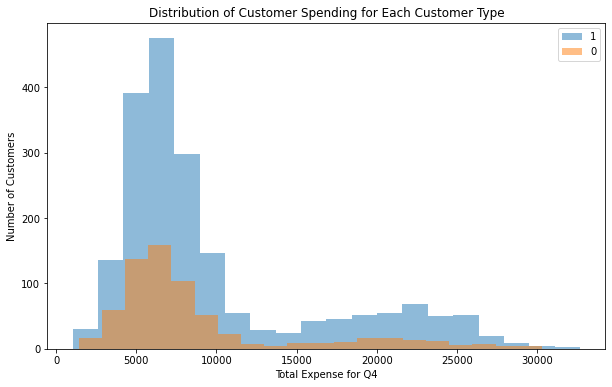

In [120]:
# Plotting the distribution of customer spending for each customer type
plt.figure(figsize=(10, 6))
for customer_type in modelling_dataset['customer_type_encoded'].unique():
    subset = modelling_dataset[modelling_dataset['customer_type_encoded'] == customer_type]
    plt.hist(subset['total_expense_2022Q4'], bins=20, alpha=0.5, label=customer_type)

plt.xlabel('Total Expense for Q4')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Spending for Each Customer Type')
plt.legend()
plt.show()

Based on visualisation, I will set the threshold of a high spender to be 15,000.

In [121]:
# identify high spenders
threshold = 15000
dtc_dataset = modelling_dataset.copy() # retain og dataset for regression
dtc_dataset['high_spender'] = np.where(dtc_dataset['total_expense_2022Q4'] > threshold, 1, 0)

In [122]:
dtc_dataset.head()

,visit_frequency,Automotive,Clothing,Toys,Sports,customer_type_encoded,Total_Items,Books,Electronics,Furniture,Health & Beauty,Stationery,cross-selling_count,Groceries,total_discount,total_expense_2022Q4,high_spender
0,47,4,3,5,3,1,258,3,5,0,2,2,10.0,30,1483.92,9901.78,0
1,54,0,2,0,2,1,660,2,3,1,1,2,0.0,41,1108.60,5642.93,0
2,58,2,1,2,1,1,776,0,1,2,1,4,2.0,46,1062.42,4643.73,0
3,41,6,4,2,1,1,233,0,3,2,4,4,6.0,21,1618.55,6567.15,0
4,45,3,2,2,2,1,194,4,5,3,2,4,4.0,22,889.95,9050.38,0


In [123]:
dtc_dataset.drop(columns=TARGET_COLUMN, inplace=True)

In [124]:
dtc_dataset.high_spender.value_counts()

0    2139
1     509
Name: high_spender, dtype: int64

In [125]:
from sklearn.tree import DecisionTreeClassifier

X_dtc = dtc_dataset.drop(['high_spender'], axis=1)  # predictors
y_dtc = dtc_dataset['high_spender']                 # target variable

# Split the data into training and testing sets
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(X_dtc, y_dtc, test_size=0.2, random_state=42)

# Create a Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=SEED)

# Define hyperparameters for GridSearch
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15]  # Adjust the depth based on your data and requirements
}

# Perform GridSearch to find the best hyperparameters
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_dtc, y_train_dtc)

# Get the best hyperparameters and create a pruned Decision Tree
best_params = grid_search.best_params_
dtc = DecisionTreeClassifier(**best_params, random_state=SEED)

# Fit the pruned model on the training data
dtc.fit(X_train_dtc, y_train_dtc)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=2202934,
                       splitter='random')

### Check (Random Forest):

In [126]:
# Print feature importances
feature_importances = list(zip(X.columns, rf_regressor.feature_importances_))
feature_importances_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)

print('Training performance')
mape_train, r2_train = evaluate_model(rf_regressor, X_train, y_train, 'Train')

print('\nTesting performance')
mape_test, r2_test = evaluate_model(rf_regressor, X_test, y_test, 'Test')

store_model('Random Forest', mape_test, r2_test, mape_train, r2_train, list(X.columns))

                  Feature  Importance
6             Total_Items    0.231728
0         visit_frequency    0.227555
13              Groceries    0.158312
8             Electronics    0.100414
1              Automotive    0.098259
9               Furniture    0.095152
14         total_discount    0.062111
12    cross-selling_count    0.017225
10        Health & Beauty    0.002234
11             Stationery    0.001588
2                Clothing    0.001544
3                    Toys    0.001365
7                   Books    0.001231
4                  Sports    0.000841
5   customer_type_encoded    0.000441
Training performance
Mean Absolute Percentage Error on Train Set: 0.26
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.29
R-squared on Test Set: 0.83


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
0,Benchmark DTR,0.404825,0.633473,0.0,1.0,None
1,Hyperparameter tuning,0.29978,0.824805,0.271244,0.838599,"{'criterion': 'squared_error', 'max_depth': No..."
2,one-hot customer,0.302129,0.818456,0.273938,0.841177,"[total_items_2022Q1, total_expense_2022Q1, tot..."
3,target-encode customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
7,unique categories,0.30118,0.821406,0.274541,0.839076,"[total_items_2022Q1, total_expense_2022Q1, tot..."
8,categories count,0.304477,0.818692,0.274094,0.841948,"[total_items_2022Q1, total_expense_2022Q1, tot..."
9,feature selection,0.302182,0.820866,0.272251,0.838969,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Check (Decision Tree Classifier):

In [127]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Print feature importances
feature_importances = list(zip(X.columns, dtc.feature_importances_))
feature_importances_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)

# Evaluate the model on the training set
print('\nTraining performance')
accuracy_train = accuracy_score(y_train_dtc, dtc.predict(X_train_dtc))
precision_train = precision_score(y_train_dtc, dtc.predict(X_train_dtc), pos_label=1)
recall_train = recall_score(y_train_dtc, dtc.predict(X_train_dtc), pos_label=1)

print(f"Accuracy: {accuracy_train}")
print(f"Precision for class 1: {precision_train}")
print(f"Recall for class 1: {recall_train}")

# Evaluate the model on the testing set
print('\nTesting performance')
accuracy_test = accuracy_score(y_test_dtc, dtc.predict(X_test_dtc))
precision_test = precision_score(y_test_dtc, dtc.predict(X_test_dtc), pos_label=1)
recall_test = recall_score(y_test_dtc, dtc.predict(X_test_dtc), pos_label=1)

print(f"Accuracy: {accuracy_test}")
print(f"Precision for class 1: {precision_test}")
print(f"Recall for class 1: {recall_test}")

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test_dtc, dtc.predict(X_test_dtc))
print("\nConfusion Matrix (Testing Set):\n", conf_matrix_test)

                  Feature  Importance
9               Furniture    0.779314
0         visit_frequency    0.183825
6             Total_Items    0.019883
13              Groceries    0.005135
8             Electronics    0.002573
1              Automotive    0.002507
11             Stationery    0.002252
7                   Books    0.001713
2                Clothing    0.001690
5   customer_type_encoded    0.001107
3                    Toys    0.000000
4                  Sports    0.000000
10        Health & Beauty    0.000000
12    cross-selling_count    0.000000
14         total_discount    0.000000

Training performance
Accuracy: 0.9886685552407932
Precision for class 1: 0.946987951807229
Recall for class 1: 0.9949367088607595

Testing performance
Accuracy: 0.9792452830188679
Precision for class 1: 0.9256198347107438
Recall for class 1: 0.9824561403508771

Confusion Matrix (Testing Set):
 [[407   9]
 [  2 112]]


Impressive performance from DTC as accuracy in predicting a high spending customer is 98%. The misclassification rate is insignificantly low, indicating that this model is robust with high accuracy in predicting a potential high spending customer for Q4.

This suggests that I can **use DTC for identifying and understanding key drivers of customer engagement** (what drives customers to become a high spender) since the accuracy of DTC is high enough for me to be certain and trust the model.

### Act:

In [128]:
results.sort_values('MAPE Test')

,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters
19,Random Forest,0.285859,0.828462,0.259832,0.840897,"[visit_frequency, Automotive, Clothing, Toys, ..."
17,Final DTR,0.293519,0.821414,0.268925,0.811585,"[visit_frequency, Automotive, Clothing, Toys, ..."
14,total discount,0.294723,0.829327,0.27072,0.839076,"[customer_type_encoded, total_expense_Q1Q2, To..."
15,total discount percentage,0.294866,0.827253,0.271025,0.838973,"[customer_type_encoded, total_expense_Q1Q2, To..."
13,cross selling,0.295807,0.816563,0.26862,0.841018,"[customer_type_encoded, total_expense_Q1Q2, To..."
11,aggregating Q1Q2,0.296883,0.8226,0.271016,0.838572,"[customer_type_encoded, Automotive, Books, Clo..."
18,Final DTR dropping features,0.297369,0.814867,0.258358,0.837832,"[visit_frequency, Automotive, Clothing, Toys, ..."
4,ordinal-encode customer,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
6,Expenses DTR,0.298507,0.826102,0.271863,0.838032,"[total_items_2022Q1, total_expense_2022Q1, tot..."
5,ordinal encode 2 customer,0.299122,0.827664,0.271945,0.838193,"[total_items_2022Q1, total_expense_2022Q1, tot..."


### Selected Model:
I will deploy Random Forest Regressor (RF) instead of Decision Tree Classifier (DTC) despite DTC having significantly stronger accuracy. This is because RF is robust enough for business usage and is more useful than DTC since RF provides a figure of total expense for the buisness user to know how much revenue they could expect from a customer - quantifiable measure to benchmark the business performance, while no financial figures can be derived from DTC. DTC is useful in understanding drivers of customer engagement due to its 90+% accuracy in predicting a high spender, however RF is more useful to be deployed for usage as it shows the business' expected revenue from a customer.

Another limitation about DTC is that its unable to adjust to growth (e.g. the majority of customers start spending over 15,000, pushing up the distribution). The threshold for high spending customer may change overtime, making it challenging and unfeasible to implement a DTC to predict high spending customer for 20XXQ4 when we do not have access to 20XXQ4's data to identify the threshold of a high spender.

## generate visuals for model interpretation's documentation and presentation